# Forex forecasting using LGBM

We will use following imports

In [77]:
import sys
!{sys.executable} -m pip install numpy pandas lightgbm seaborn matplotlib scikit-learn
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Load the forex M1 data

In [78]:
pairs = [
    'EURUSD',
    'EURGBP',
    'EURJPY',
    'EURCHF',
    'EURAUD',
    'EURCAD',
    'GBPUSD',
    'AUDUSD',
    'USDCAD',
    'USDCHF',
    'USDJPY'
]
data_location = './data'
dfs = {}
for pair in pairs:
    dfs[pair] = pd.read_csv(data_location + f'/{pair}_M1.csv')

## Exploratory data analysis

In [79]:
dfs['EURUSD'].head()

,Date,Open,High,Low,Close,Volume
0,2021-04-06 18:54,1.18714,1.18717,1.18710,1.18714,41
1,2021-04-06 18:55,1.18713,1.18713,1.18691,1.18694,44
2,2021-04-06 18:56,1.18694,1.18697,1.18689,1.18697,66
3,2021-04-06 18:57,1.18698,1.18700,1.18693,1.18698,38
4,2021-04-06 18:58,1.18698,1.18711,1.18698,1.18710,44


In [80]:
dfs['EURUSD'].describe()

,Open,High,Low,Close,Volume
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,1.189036,1.189093,1.188978,1.189035,58.235770
std,0.018745,0.018748,0.018742,0.018745,64.767384
min,1.152460,1.152520,1.152420,1.152460,1.000000
25%,1.176160,1.176220,1.176090,1.176160,18.000000
50%,1.186050,1.186110,1.186000,1.186050,41.000000
75%,1.205410,1.205480,1.205350,1.205412,77.000000
max,1.226550,1.226640,1.226490,1.226560,2084.000000


In [81]:
dfs['EURGBP'].describe()

,Open,High,Low,Close,Volume
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.857858,0.857905,0.857812,0.857858,55.753910
std,0.006037,0.006040,0.006033,0.006037,54.323367
min,0.842060,0.842340,0.842060,0.842310,1.000000
25%,0.853900,0.853940,0.853860,0.853900,19.000000
50%,0.858090,0.858140,0.858040,0.858090,41.000000
75%,0.861440,0.861480,0.861393,0.861440,76.000000
max,0.871890,0.871930,0.871860,0.871900,965.000000


In [82]:
dfs['GBPUSD'].describe()

,Open,High,Low,Close,Volume
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,1.385910,1.385996,1.385824,1.385909,52.835540
std,0.017286,0.017286,0.017285,0.017286,60.172192
min,1.341250,1.341310,1.341160,1.341230,1.000000
25%,1.374790,1.374870,1.374700,1.374780,16.000000
50%,1.384020,1.384090,1.383950,1.384010,36.000000
75%,1.393740,1.393820,1.393650,1.393740,70.000000
max,1.424630,1.424910,1.424420,1.424610,1827.000000


### Feature correlation

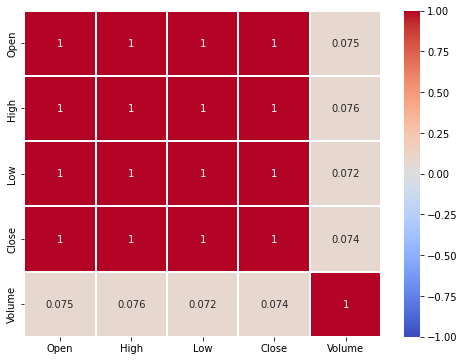

In [83]:
plt.figure(figsize=(8,6))
sns.heatmap(dfs['EURUSD'][['Open', 'High', 'Low', 'Close', 'Volume']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

### Correlation between currency pairs' close prices

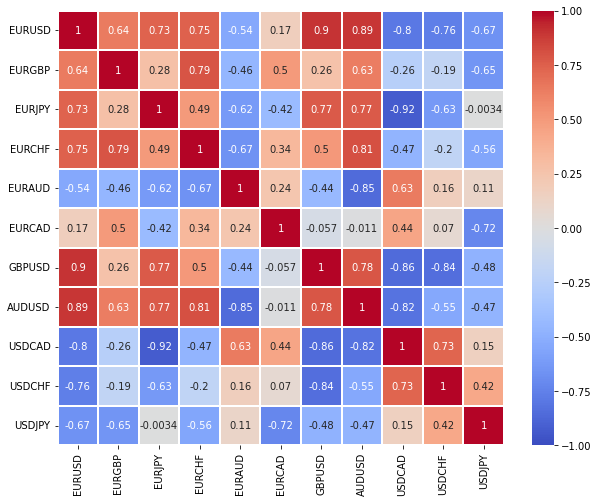

In [84]:
correlation_check = pd.DataFrame()
for pair in pairs:
    correlation_check[pair] = dfs[pair]['Close']
plt.figure(figsize=(10,8))
sns.heatmap(correlation_check.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

### Correlation between traded volumes

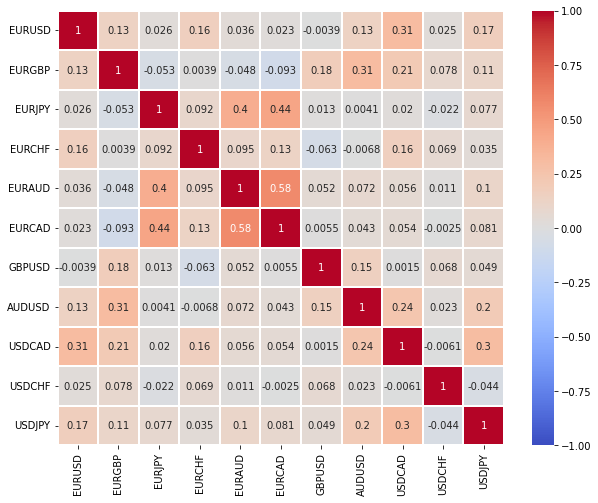

In [85]:
correlation_check = pd.DataFrame()
for pair in pairs:
    correlation_check[pair] = dfs[pair]['Volume']
plt.figure(figsize=(10,8))
sns.heatmap(correlation_check.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

## Feature extraction

In [86]:
def hlco_ratio(df: pd.DataFrame): 
    return (df['High'] - df['Low'])/(df['Close']-df['Open'])

def upper_shadow(df: pd.DataFrame):
    return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df: pd.DataFrame):
    return np.minimum(df['Close'], df['Open']) - df['Low']

def vwap(df: pd.DataFrame):
    return (df['Close'] * df['Volume']).rolling(60 * 24).sum() / df['Volume'].rolling(60 * 24).sum()

def get_features(df: pd.DataFrame):
    df_feat = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    df_feat['Hlco_ratio'] = hlco_ratio(df)
    df_feat['Upper_shadow'] = upper_shadow(df)
    df_feat['Lower_shadow'] = lower_shadow(df)
    df_feat['VWAP'] = vwap(df)
    return df_feat


Lets see how our extracted features look like

In [87]:
eurusd_df = get_features(dfs['EURUSD'])
eurusd_df.describe()

,Open,High,Low,Close,Volume,Hlco_ratio,Upper_shadow,Lower_shadow,VWAP
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,194636.0,200000.000000,200000.000000,198561.000000
mean,1.189036,1.189093,1.188978,1.189035,58.235770,inf,0.000024,0.000024,1.189119
std,0.018745,0.018748,0.018742,0.018745,64.767384,NaN,0.000036,0.000037,0.018675
min,1.152460,1.152520,1.152420,1.152460,1.000000,-88.0,0.000000,0.000000,1.154474
25%,1.176160,1.176220,1.176090,1.176160,18.000000,-1.5,0.000000,0.000000,1.176302
50%,1.186050,1.186110,1.186000,1.186050,41.000000,1.0,0.000010,0.000010,1.185928
75%,1.205410,1.205480,1.205350,1.205412,77.000000,2.0,0.000030,0.000030,1.205034
max,1.226550,1.226640,1.226490,1.226560,2084.000000,inf,0.001610,0.002350,1.225026


As we can see we have some infinite and NaN values which we will have to handle later

## Creating targets for prediction

As a target I will choose return after 15 minutes, i.e. the close price shifted by 15 rows over the actual close price

In [88]:
def get_target(df: pd.DataFrame, interval=15):
    df_target = pd.DataFrame()
    df_target['Target'] = df['Close'].shift(-interval) / df['Close']
    return df_target

In [89]:
eurusd_target = get_target(dfs['EURUSD'])
eurusd_target.describe()

,Target
count,199985.000000
mean,0.999999
std,0.000329
min,0.994098
25%,0.999847
50%,1.000000
75%,1.000152
max,1.006151


In [94]:
models = {}
datas = {}
Xs = {}
ys = {}
for pair in pairs:
    print(f'Creating model for "{pair}"')
    datas[pair] = get_features(dfs[pair]).copy()
    datas[pair]['Target'] = get_target(dfs[pair])['Target']
    datas[pair].replace([np.inf, -np.inf], np.nan, inplace=True)
    datas[pair] = datas[pair].dropna(how='any')
    Xs[pair] = datas[pair].drop('Target', axis=1)
    ys[pair] = datas[pair]['Target']
    models[pair] = lgbm.LGBMRegressor(
        objective='tweedie',
        n_estimators=100,
        learning_rate=0.09,
        num_leaves=71,
        max_depth=6
    )
    models[pair].fit(Xs[pair], ys[pair])

Creating model for "EURUSD"
Creating model for "EURGBP"
Creating model for "EURJPY"
Creating model for "EURCHF"
Creating model for "EURAUD"
Creating model for "EURCAD"
Creating model for "GBPUSD"
Creating model for "AUDUSD"
Creating model for "USDCAD"
Creating model for "USDCHF"
Creating model for "USDJPY"


## Evaluation

In [95]:
df_results = pd.DataFrame()
df_results['y'] = ys['EURUSD']
df_results['y_pred'] = models['EURUSD'].predict(Xs['EURUSD'])

df_results.describe()

,y,y_pred
count,178300.000000,178300.000000
mean,0.999998,0.999998
std,0.000338,0.000048
min,0.994098,0.998808
25%,0.999840,0.999988
50%,1.000000,0.999997
75%,1.000158,1.000008
max,1.006151,1.002013


In [96]:
res_corr = {}
res_mae = {}
res_rmse = {}
for pair in pairs:
    print(f'Evaluation of "{pair}"')
    y_pred = models[pair].predict(Xs[pair])
    df_results = pd.DataFrame()
    df_results['y'] = ys[pair]
    df_results['y_pred'] = models[pair].predict(Xs[pair])
    res_corr[pair] = df_results.corr()['y']['y_pred']
    res_mae[pair] = np.absolute(df_results['y'] - df_results['y_pred']).sum() / y_pred.shape[0]
    res_rmse[pair] = np.power(np.square(df_results['y'] - df_results['y_pred']).sum() / y_pred.shape[0], 0.5)
    print(f"\tcorrelation: {res_corr[pair]}")
    print(f"\tmae:         {res_mae[pair]}")
    print(f"\trmse:        {res_rmse[pair]}")
print(f"Average correlation: {np.average(list(res_corr.values()))}")
print(f"Average mae:         {np.average(list(res_mae.values()))}")
print(f"Average rmse:        {np.average(list(res_rmse.values()))}")

Evaluation of "EURUSD"
	correlation: 0.3422478055562347
	mae:         0.0002220013232836421
	rmse:        0.0003249100193912122
Evaluation of "EURGBP"
	correlation: 0.328322559897566
	mae:         0.00022831090919067003
	rmse:        0.00032652840927019285
Evaluation of "EURJPY"
	correlation: 0.3426917278683218
	mae:         0.00023156255613700295
	rmse:        0.00032602563167960757
Evaluation of "EURCHF"
	correlation: 0.3410509227820788
	mae:         0.00016898396648536585
	rmse:        0.00024045219749772937
Evaluation of "EURAUD"
	correlation: 0.3448426671410403
	mae:         0.0002847509672679972
	rmse:        0.00039189286664310225
Evaluation of "EURCAD"
	correlation: 0.3572763139520541
	mae:         0.0002628217526228403
	rmse:        0.00037197819448981067
Evaluation of "GBPUSD"
	correlation: 0.3476304699258388
	mae:         0.00028400905549826023
	rmse:        0.00040538137288023614
Evaluation of "AUDUSD"
	correlation: 0.3461114168744716
	mae:         0.00037869588333302583
	r